In [3]:
import os
import cv2
import imghdr
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\Gauri\AppData\Local\Temp\ipykernel_13556\3863879477.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
import zipfile

# Specify the path to your ZIP file
zip_file_path = r'C:\Users\Gauri\Desktop\VS code\ML\Corn Disease\folder\data_new.zip'

# Open the ZIP file in read mode
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all files to a directory
    zip_ref.extractall('zip_data')  # 'extracted_data' is the folder where the files will be extracted

print("Files extracted successfully.")

Files extracted successfully.


In [5]:
!splitfolders --ratio 0.8 0.1 0.1 -- ./zipp_data


Copying files: 0 files [00:00, ? files/s]
Copying files: 84 files [00:00, 839.58 files/s]
Copying files: 180 files [00:00, 906.39 files/s]
Copying files: 271 files [00:00, 882.51 files/s]
Copying files: 377 files [00:00, 947.82 files/s]
Copying files: 480 files [00:00, 975.70 files/s]
Copying files: 578 files [00:00, 873.69 files/s]
Copying files: 687 files [00:00, 937.10 files/s]
Copying files: 824 files [00:00, 1066.90 files/s]
Copying files: 933 files [00:00, 1069.05 files/s]
Copying files: 1042 files [00:01, 1025.61 files/s]
Copying files: 1146 files [00:01, 991.31 files/s] 
Copying files: 1281 files [00:01, 1092.18 files/s]
Copying files: 1410 files [00:01, 1147.32 files/s]
Copying files: 1554 files [00:01, 1231.02 files/s]
Copying files: 1679 files [00:01, 1141.01 files/s]
Copying files: 1799 files [00:01, 1155.81 files/s]
Copying files: 1947 files [00:01, 1243.33 files/s]
Copying files: 2073 files [00:01, 1065.81 files/s]
Copying files: 2185 files [00:02, 951.27 files/s] 
Copyi

In [6]:
# Load datasets using raw string literals
common_rust = pd.read_csv(r'C:\Users\Gauri\Desktop\VS code\ML\Corn Disease\rust.csv')
blight = pd.read_csv(r'C:\Users\Gauri\Desktop\VS code\ML\Corn Disease\blight.csv')
gray_spot = pd.read_csv(r'C:\Users\Gauri\Desktop\VS code\ML\Corn Disease\spot.csv')

In [7]:
# Combine all datasets into one
common_rust['Disease'] = 'Common Rust'
blight['Disease'] = 'Northern Corn Leaf Blight'
gray_spot['Disease'] = 'Gray Leaf Spot'
data = pd.concat([common_rust, blight, gray_spot])

In [8]:
data['Symptoms'] = data[['Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']].agg(' '.join, axis=1)

In [9]:
# Features and labels
X = data['Symptoms']
y = data['Disease']


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Create a pipeline for TF-IDF Vectorizer and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),        # Convert symptoms text to vectors
    ('clf', LogisticRegression())        # Logistic Regression classifier
])

In [12]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])

In [13]:
import pickle
with open(r'C:\Users\Gauri\Desktop\VS code\ML\Corn Disease\folder\tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(pipeline.named_steps['tfidf'], f)


In [14]:
# Predict and evaluate the model
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Text Model Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Text Model Accuracy: 1.00
                           precision    recall  f1-score   support

              Common Rust       1.00      1.00      1.00       104
           Gray Leaf Spot       1.00      1.00      1.00       110
Northern Corn Leaf Blight       1.00      1.00      1.00        86

                 accuracy                           1.00       300
                macro avg       1.00      1.00      1.00       300
             weighted avg       1.00      1.00      1.00       300



In [15]:
# Extract TF-IDF vectors from text data for the fusion model
text_data = pipeline.named_steps['tfidf'].transform(X).toarray()


In [16]:
# Step 1: Prepare Image Data
IMAGE_SIZE = 256
CHANNELS = 3

In [17]:
# Image data generators for training, validation, and testing
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
        'output/train',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)


Found 1760 images belonging to 4 classes.


In [18]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
        'output/val',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 220 images belonging to 4 classes.


In [19]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        'output/test',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 221 images belonging to 4 classes.


In [20]:
class_names = list(train_generator.class_indices.keys())

In [32]:
# Step 3: Build Image Model (CNN)
image_model = models.Sequential([
    layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu')
])


In [33]:
# Step 4: Fusion Model (Combining Image and Text Features)
# Define inputs for image and text data
image_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
text_input = layers.Input(shape=(text_data.shape[1],))

In [34]:
# Process the image data
image_features = image_model(image_input)


In [35]:
# Process the text data
text_features = layers.Dense(128, activation='relu')(text_input)


In [36]:
# Concatenate image and text features
combined_features = layers.concatenate([image_features, text_features])


In [37]:
from tensorflow.keras.layers import Dense, Dropout, Concatenate

# Assuming `text_model` and `image_model` have been defined
# Concatenate text and image features
combined_features = Concatenate()([image_features, text_features])

n_classes = len(class_names)
# Additional Dense layers for fusion
x = Dense(128, activation='relu')(combined_features)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization

# Output layer
output = Dense(n_classes, activation='softmax')(x)

# Define the final model
fusion_model = models.Model(inputs=[image_input, text_input], outputs=output)
fusion_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [38]:
# Step 5: Train the Fusion Model

# Get image_data from train generator (For demonstration, using one batch)
for image_batch, label_batch in train_generator:
    image_data = image_batch
    labels = label_batch
    break


In [39]:
# Make sure text_data corresponds to the same number of samples
# Resize text_data if needed (this step is dataset dependent)
text_data_train = text_data[:len(image_data)]


In [40]:
# Train the fusion model
history = fusion_model.fit(
    [image_data, text_data_train],    # Image and text data as inputs
    labels,                           # Labels for training
    epochs=40,                        # Number of epochs
    batch_size=32,                    # Batch size
    validation_split=0.2              # Split for validation
)


Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.1200 - loss: 1.4099 - val_accuracy: 0.2857 - val_loss: 1.9871
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2800 - loss: 2.5962 - val_accuracy: 0.2857 - val_loss: 1.3536
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3600 - loss: 1.5503 - val_accuracy: 0.5714 - val_loss: 1.3294
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3600 - loss: 1.5478 - val_accuracy: 0.4286 - val_loss: 1.3243
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2000 - loss: 1.4836 - val_accuracy: 0.5714 - val_loss: 1.3572
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3200 - loss: 1.3056 - val_accuracy: 0.2857 - val_loss: 1.3534
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2800 - loss: 1.3902 - val_accuracy: 0.5714 - val_loss: 1.3487
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4000 - loss: 1.2789 - val_accuracy: 0.4286 - val_loss: 1.3437
Epoch 9/40
1/1 ━

In [44]:
fusion_model.save(r'C:\Users\Gauri\Desktop\VS code\ML\Corn Disease\folder\corn_disease_model.h5')


First image to predict
Actual label: Common_Rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
Predicted label: Common_Rust
Confidence: 100.0


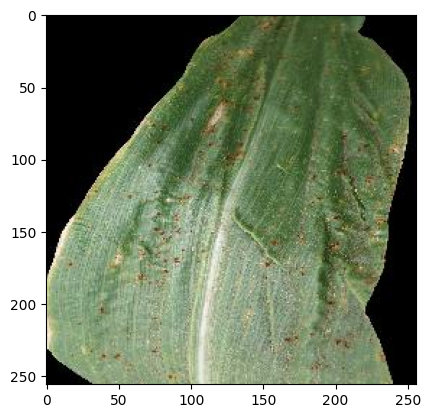

In [42]:
# Step 6: Testing and Predicting
def predict(model, img, text_input):
    img_array = tf.expand_dims(img, 0)
    text_array = np.expand_dims(text_input, 0)

    predictions = model.predict([img_array, text_array])

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Testing the prediction with images and symptoms
for image_batch, label_batch in test_generator:
    first_image = image_batch[0]
    first_label = int(label_batch[0])
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])
    
    # Use the corresponding symptom from your dataset for the first image
    corresponding_symptom = data.iloc[y_test.index[0]]['Symptoms']  # Adjust indexing as needed
    predicted_class, confidence = predict(fusion_model, first_image, pipeline.named_steps['tfidf'].transform([corresponding_symptom]).toarray()[0])
    
    print("Predicted label:", predicted_class)
    print("Confidence:", confidence)
    
    break


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


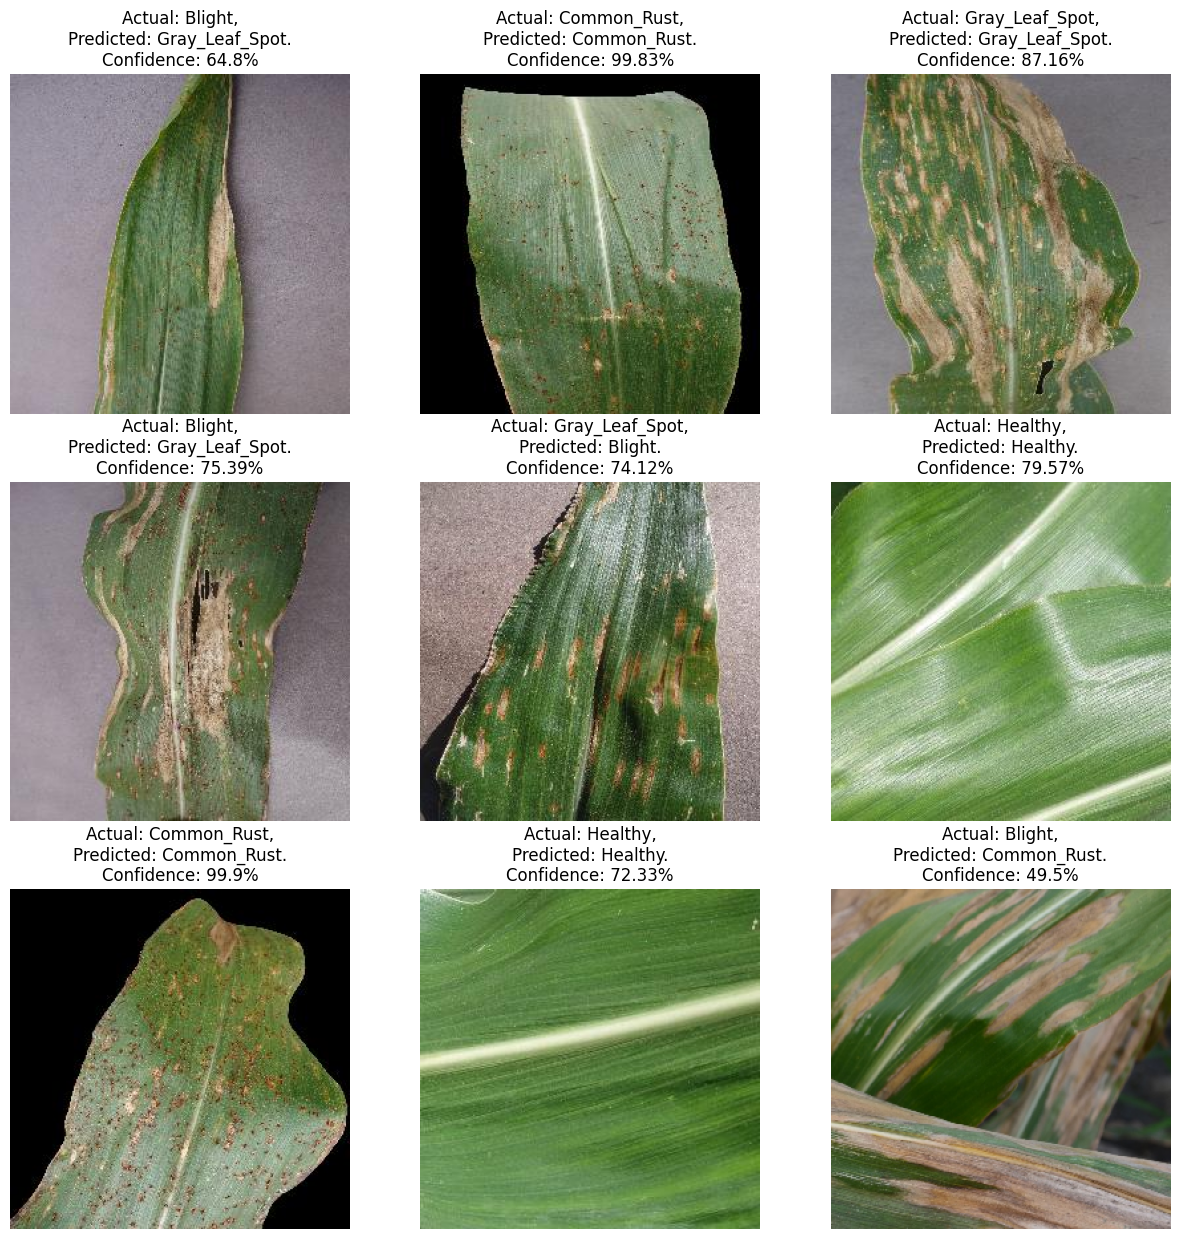

In [31]:
# Step 7: Visualize Predictions
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        corresponding_symptom = data.iloc[y_test.index[i]]['Symptoms']  # Adjust indexing as needed
        predicted_class, confidence = predict(fusion_model, images[i], pipeline.named_steps['tfidf'].transform([corresponding_symptom]).toarray()[0])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}%")
        plt.axis("off")
    break

In [30]:
import cv2
from tkinter import filedialog
from tkinter import Tk

# Function to upload and process an image from the user
def upload_image():
    Tk().withdraw()  # Hide the root window
    img_path = filedialog.askopenfilename(title="Select Image", filetypes=[("Image files", "*.jpg;*.png")])
    if img_path:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to match input size
        img = img / 255.0  # Normalize image (rescaling)
        return img
    else:
        print("No image selected!")
        return None

# Function to take user input for symptoms and process it
def input_symptoms():
    symptoms = input("Please enter the symptoms: ")
    symptoms_vector = pipeline.named_steps['tfidf'].transform([symptoms]).toarray()[0]  # Transform to TF-IDF vector
    return symptoms_vector

# Function to make predictions using the fusion model
def predict_from_user_input(fusion_model, class_names):
    img = upload_image()  # Get the image from the user
    if img is None:
        return  # Exit if no image is provided
    
    symptoms_vector = input_symptoms()  # Get the symptoms from the user

    img = np.expand_dims(img, axis=0)  # Expand dimensions to match model input (batch size 1)
    symptoms_vector = np.expand_dims(symptoms_vector, axis=0)  # Expand symptoms input

    # Predict using the fusion model
    predictions = fusion_model.predict([img, symptoms_vector])

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    print(f"Predicted Disease: {predicted_class}")
    print(f"Confidence: {confidence}%")

# Call the function to predict using user input
predict_from_user_input(fusion_model, class_names)


Please enter the symptoms:  


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted Disease: Common_Rust
Confidence: 100.0%


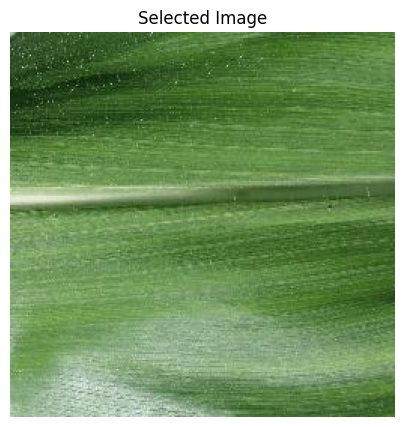

Please enter the symptoms:  


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Predicted Disease: Healthy
Confidence: 81.54%


In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tkinter import filedialog
from tkinter import Tk

# Function to upload and process an image from the user
def upload_image():
    Tk().withdraw()  # Hide the root window
    img_path = filedialog.askopenfilename(title="Select Image", filetypes=[("Image files", "*.jpg;*.png")])
    if img_path:
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to match input size
        img_resized = img_resized / 255.0  # Normalize image (rescaling)

        # Show the selected image using matplotlib
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR (OpenCV) to RGB (matplotlib)
        plt.title("Selected Image")
        plt.axis('off')  # Hide axis
        plt.show()

        return img_resized
    else:
        print("No image selected!")
        return None

# Function to take user input for symptoms and process it
def input_symptoms():
    symptoms = input("Please enter the symptoms: ")
    symptoms_vector = pipeline.named_steps['tfidf'].transform([symptoms]).toarray()[0]  # Transform to TF-IDF vector
    return symptoms_vector

# Function to make predictions using the fusion model
def predict_from_user_input(fusion_model, class_names):
    img = upload_image()  # Get the image from the user
    if img is None:
        return  # Exit if no image is provided
    
    symptoms_vector = input_symptoms()  # Get the symptoms from the user

    img = np.expand_dims(img, axis=0)  # Expand dimensions to match model input (batch size 1)
    symptoms_vector = np.expand_dims(symptoms_vector, axis=0)  # Expand symptoms input

    # Predict using the fusion model
    predictions = fusion_model.predict([img, symptoms_vector])

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    print(f"Predicted Disease: {predicted_class}")
    print(f"Confidence: {confidence}%")

# Call the function to predict using user input
predict_from_user_input(fusion_model, class_names)

#Output correct

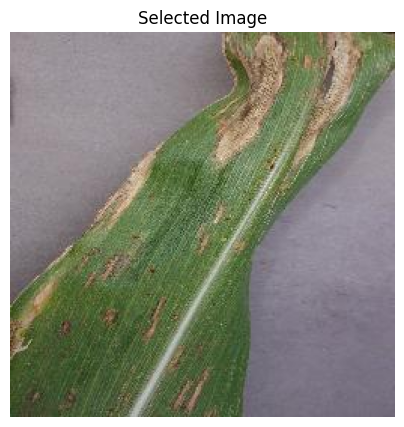

Please enter the symptoms:  


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted Disease: Blight
Confidence: 53.74%


In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tkinter import filedialog
from tkinter import Tk

# Function to upload and process an image from the user
def upload_image():
    Tk().withdraw()  # Hide the root window
    img_path = filedialog.askopenfilename(title="Select Image", filetypes=[("Image files", "*.jpg;*.png")])
    if img_path:
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to match input size
        img_resized = img_resized / 255.0  # Normalize image (rescaling)

        # Show the selected image using matplotlib
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR (OpenCV) to RGB (matplotlib)
        plt.title("Selected Image")
        plt.axis('off')  # Hide axis
        plt.show()

        return img_resized
    else:
        print("No image selected!")
        return None

# Function to take user input for symptoms and process it
def input_symptoms():
    symptoms = input("Please enter the symptoms: ")
    symptoms_vector = pipeline.named_steps['tfidf'].transform([symptoms]).toarray()[0]  # Transform to TF-IDF vector
    return symptoms_vector

# Function to make predictions using the fusion model
def predict_from_user_input(fusion_model, class_names):
    img = upload_image()  # Get the image from the user
    if img is None:
        return  # Exit if no image is provided
    
    symptoms_vector = input_symptoms()  # Get the symptoms from the user

    img = np.expand_dims(img, axis=0)  # Expand dimensions to match model input (batch size 1)
    symptoms_vector = np.expand_dims(symptoms_vector, axis=0)  # Expand symptoms input

    # Predict using the fusion model
    predictions = fusion_model.predict([img, symptoms_vector])

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    print(f"Predicted Disease: {predicted_class}")
    print(f"Confidence: {confidence}%")

# Call the function to predict using user input
predict_from_user_input(fusion_model, class_names)

#Output correct

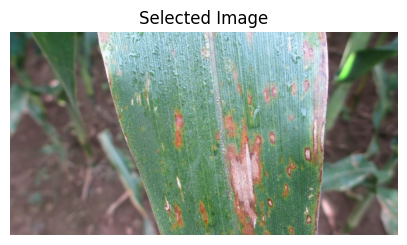

Please enter the symptoms:  


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Predicted Disease: Blight
Confidence: 95.95%


In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tkinter import filedialog
from tkinter import Tk

# Function to upload and process an image from the user
def upload_image():
    Tk().withdraw()  # Hide the root window
    img_path = filedialog.askopenfilename(title="Select Image", filetypes=[("Image files", "*.jpg;*.png")])
    if img_path:
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to match input size
        img_resized = img_resized / 255.0  # Normalize image (rescaling)

        # Show the selected image using matplotlib
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR (OpenCV) to RGB (matplotlib)
        plt.title("Selected Image")
        plt.axis('off')  # Hide axis
        plt.show()

        return img_resized
    else:
        print("No image selected!")
        return None

# Function to take user input for symptoms and process it
def input_symptoms():
    symptoms = input("Please enter the symptoms: ")
    symptoms_vector = pipeline.named_steps['tfidf'].transform([symptoms]).toarray()[0]  # Transform to TF-IDF vector
    return symptoms_vector

# Function to make predictions using the fusion model
def predict_from_user_input(fusion_model, class_names):
    img = upload_image()  # Get the image from the user
    if img is None:
        return  # Exit if no image is provided
    
    symptoms_vector = input_symptoms()  # Get the symptoms from the user

    img = np.expand_dims(img, axis=0)  # Expand dimensions to match model input (batch size 1)
    symptoms_vector = np.expand_dims(symptoms_vector, axis=0)  # Expand symptoms input

    # Predict using the fusion model
    predictions = fusion_model.predict([img, symptoms_vector])

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    print(f"Predicted Disease: {predicted_class}")
    print(f"Confidence: {confidence}%")

# Call the function to predict using user input
predict_from_user_input(fusion_model, class_names)

#Actual: Spot

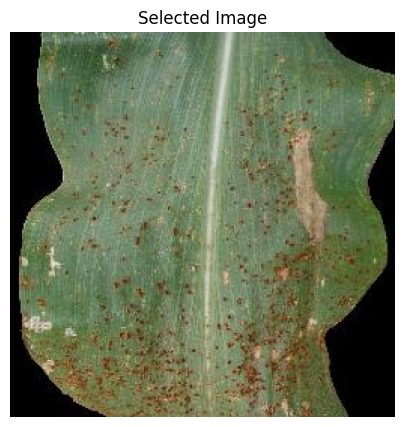

Please enter the symptoms:  


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Predicted Disease: Common_Rust
Confidence: 100.0%


In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tkinter import filedialog
from tkinter import Tk

# Function to upload and process an image from the user
def upload_image():
    Tk().withdraw()  # Hide the root window
    img_path = filedialog.askopenfilename(title="Select Image", filetypes=[("Image files", "*.jpg;*.png")])
    if img_path:
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to match input size
        img_resized = img_resized / 255.0  # Normalize image (rescaling)

        # Show the selected image using matplotlib
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR (OpenCV) to RGB (matplotlib)
        plt.title("Selected Image")
        plt.axis('off')  # Hide axis
        plt.show()

        return img_resized
    else:
        print("No image selected!")
        return None

# Function to take user input for symptoms and process it
def input_symptoms():
    symptoms = input("Please enter the symptoms: ")
    symptoms_vector = pipeline.named_steps['tfidf'].transform([symptoms]).toarray()[0]  # Transform to TF-IDF vector
    return symptoms_vector

# Function to make predictions using the fusion model
def predict_from_user_input(fusion_model, class_names):
    img = upload_image()  # Get the image from the user
    if img is None:
        return  # Exit if no image is provided
    
    symptoms_vector = input_symptoms()  # Get the symptoms from the user

    img = np.expand_dims(img, axis=0)  # Expand dimensions to match model input (batch size 1)
    symptoms_vector = np.expand_dims(symptoms_vector, axis=0)  # Expand symptoms input

    # Predict using the fusion model
    predictions = fusion_model.predict([img, symptoms_vector])

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    print(f"Predicted Disease: {predicted_class}")
    print(f"Confidence: {confidence}%")

# Call the function to predict using user input
predict_from_user_input(fusion_model, class_names)

#Output correct

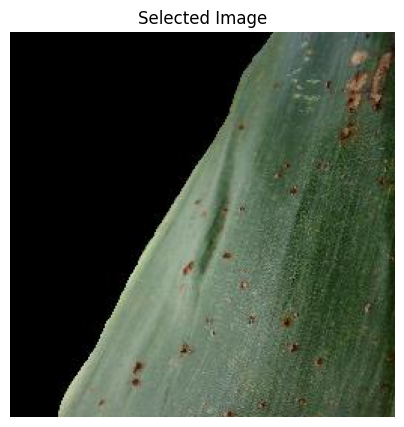

Please enter the symptoms:  Leaf deformation, Spores released during windy weather


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Predicted Disease: Common_Rust
Confidence: 100.0%


In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tkinter import filedialog
from tkinter import Tk

# Function to upload and process an image from the user
def upload_image():
    Tk().withdraw()  # Hide the root window
    img_path = filedialog.askopenfilename(title="Select Image", filetypes=[("Image files", "*.jpg;*.png")])
    if img_path:
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to match input size
        img_resized = img_resized / 255.0  # Normalize image (rescaling)

        # Show the selected image using matplotlib
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR (OpenCV) to RGB (matplotlib)
        plt.title("Selected Image")
        plt.axis('off')  # Hide axis
        plt.show()

        return img_resized
    else:
        print("No image selected!")
        return None

# Function to take user input for symptoms and process it
def input_symptoms():
    symptoms = input("Please enter the symptoms: ")
    symptoms_vector = pipeline.named_steps['tfidf'].transform([symptoms]).toarray()[0]  # Transform to TF-IDF vector
    return symptoms_vector

# Function to make predictions using the fusion model
def predict_from_user_input(fusion_model, class_names):
    img = upload_image()  # Get the image from the user
    if img is None:
        return  # Exit if no image is provided
    
    symptoms_vector = input_symptoms()  # Get the symptoms from the user

    img = np.expand_dims(img, axis=0)  # Expand dimensions to match model input (batch size 1)
    symptoms_vector = np.expand_dims(symptoms_vector, axis=0)  # Expand symptoms input

    # Predict using the fusion model
    predictions = fusion_model.predict([img, symptoms_vector])

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    print(f"Predicted Disease: {predicted_class}")
    print(f"Confidence: {confidence}%")

# Call the function to predict using user input
predict_from_user_input(fusion_model, class_names)

#Output correct